In [1]:
#importar bibliotecas
#!pip install -U scikit-learn
import pandas as pd
import numpy as np
from sklearn import preprocessing 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression , Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  GridSearchCV , train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler ,PolynomialFeatures,normalize
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.preprocessing import scale
#
#from sklearn.feature_selection import SelectKBest
#from sklearn.naive_bayes import GaussianNB
#

#from pandas.plotting import autocorrelation_plot
#from pandas.plotting import scatter_matrix
#%matplotlib inline

In [2]:
df = pd.read_csv("dados/transformado.csv", sep=",")

In [3]:
#transformando as dados categoricos como Formação, Mandante, Visitante em dados numericos
dt = pd.concat([df['formacao_mandante'],df['formacao_visitante']])

le = preprocessing.LabelEncoder()
le.fit(dt)
df['formacao_mandante'] = le.transform(df["formacao_mandante"])
df['formacao_visitante'] = le.transform(df["formacao_visitante"])



le.fit(df['vencedor'])
df['mandante'] = le.transform(df["mandante"])
df['visitante'] = le.transform(df["visitante"])

#retirando a coluna vencedor que é do tipo categorica e vamos utilizar a columa resultado, numerica.
df.drop(columns=['vencedor','rodada','total_gols'],inplace=True)
df.tail()


,partida_id,mandante,visitante,formacao_mandante,formacao_visitante,mandante_placar,visitante_placar,chutes_mandante,chutes_no_alvo_mandante,posse_de_bola_mandante,...,posse_de_bola_visitante,passes_visitante,precisao_passes_visitante,faltas_visitante,cartao_amarelo_visitante,cartao_vermelho_visitante,impedimentos_visitante,escanteios_visitante,temporada,resultado
1871,8021,15,13,9,9,2,1,17,8,0.57,...,0.43,389,0.82,8,3,1,2,1,2022,1
1872,8022,8,17,11,11,0,1,13,4,0.41,...,0.59,463,0.82,15,2,0,0,9,2022,2
1873,8023,12,4,9,11,0,1,17,4,0.59,...,0.41,351,0.82,19,6,0,0,4,2022,2
1874,8024,21,23,11,11,3,0,15,8,0.48,...,0.52,306,0.82,17,3,0,2,5,2022,1
1875,8025,19,26,11,7,0,4,6,2,0.35,...,0.65,591,0.90,14,1,0,0,4,2022,2


In [4]:
#criando dataset auxiliar
df_aux = pd.DataFrame(df[(df['temporada']==2022)])

# Eliminando os dados de df_aux do df_model
df_model = df.drop(index = df_aux.index)

#arrumando index de df_aux
df_aux.reset_index(inplace = True)
df_aux.drop('index', axis = 1, inplace = True)

print("-----------------------------------")
print("* SHAPE DOS MODELOS")
print ("O dataset DF_MODEL será utilizado para TESTE, ele contêm {} Linhas  e  {} Colunas : ".format( df_model.shape[0] , df_model.shape[1]))
print ("O dataset DF_AUX será utilizado para VALIDAÇÃO do TESTE E TREINO, ele contem {} Linhas  e  {} Colunas : ".format( df_aux.shape[0] , df_aux.shape[1]))
print(" ")
print("-----------------------------------")
print("* TEMPORADAS DO MODELO ")
print("Temporada Modelo", df_model.temporada.unique(), " Qtd linhas x colunas", df_model.shape)
print("Temporada Auxiliar" , df_aux.temporada.unique() , " Qtd linhas x colunas",df_aux.shape)

-----------------------------------
* SHAPE DOS MODELOS
O dataset DF_MODEL será utilizado para TESTE, ele contêm 1496 Linhas  e  30 Colunas : 
O dataset DF_AUX será utilizado para VALIDAÇÃO do TESTE E TREINO, ele contem 380 Linhas  e  30 Colunas : 
 
-----------------------------------
* TEMPORADAS DO MODELO 
Temporada Modelo [2018 2019 2020 2021]  Qtd linhas x colunas (1496, 30)
Temporada Auxiliar [2022]  Qtd linhas x colunas (380, 30)


In [11]:
#separar features e label
label_model = df[(df['temporada'] <= 2021)]['resultado']
label_aux = df[(df['temporada'] == 2022)]['resultado']


features_model = df[(df['temporada'] <= 2021)]
features_aux = df[(df['temporada'] == 2022)]

features_model = features_model.drop(columns=['resultado'])
features_aux = features_aux.drop(columns=['resultado'])

In [13]:
#Devido as diferenças numericas entre os dados, vamos normaliza-los.
# Normalizando os dados de entrada(features)

scaler = MinMaxScaler().fit(features_model)
features_scale_model = scaler.transform(features_model)
features_scale_aux = scaler.transform(features_aux)


In [14]:
# Separando os dados de Treino e Teste, com 20% para testes, lembrando que o df_aux só será utilizando para validação do ML

SEED = 23
np.random.seed(SEED)
X_train, X_test, y_train, y_test = train_test_split(features_scale_model, label_model, test_size = 0.20, stratify = label_model )

print('O dataset de treino possui {} linhas e o de teste {} linhas.'.format(X_train.shape[0], X_test.shape[0]))

O dataset de treino possui 1196 linhas e o de teste 300 linhas.


In [15]:
#Os modelos que iremos utilizar é LogisticRegression , SVC , Decision Tree

model_logr = LogisticRegression(multi_class='multinomial',max_iter=2000)
model_svc = SVC()
model_dtc = DecisionTreeClassifier(max_depth=3)
model_rand = RandomForestClassifier(n_estimators=100)

models = [model_logr,model_svc,model_dtc,model_rand]


#Treinando os modelos e informando a Acurácia 
for model in models:
    model.fit(X_train,y_train)
    pred= model.predict(X_test)
    svc_acc = accuracy_score(y_test, pred)
    f1=f1_score(y_test,pred, average='micro')
    recal = recall_score(y_test,pred, average='micro')

    print('MODELO {} '.format(model))
    print(" ")
    print('Acurácia : {}'.format(svc_acc))
    print('F1 Score : {}'.format(f1))
    print('recall : {}'.format(recal))
    print(" ")
    print(" ")

MODELO LogisticRegression(max_iter=2000, multi_class='multinomial') 
 
Acurácia : 0.9566666666666667
F1 Score : 0.9566666666666667
recall : 0.9566666666666667
 
 
MODELO SVC() 
 
Acurácia : 0.9833333333333333
F1 Score : 0.9833333333333333
recall : 0.9833333333333333
 
 
MODELO DecisionTreeClassifier(max_depth=3) 
 
Acurácia : 0.7966666666666666
F1 Score : 0.7966666666666665
recall : 0.7966666666666666
 
 
MODELO RandomForestClassifier() 
 
Acurácia : 0.97
F1 Score : 0.97
recall : 0.97
 
 


In [22]:
#Vamos realizar a validação dos modelos acima


SEED = 42
np.random.seed(SEED)

#Utilizando o StratifiedKFold temos que ao treinar e testar os modelos com os folds contendo a mesma proporção de informações
cv = StratifiedKFold(n_splits = 5, shuffle = True)


print("******* CROSS VALIDATION ******* ")
print(" ")
print(" ")
for model in models:
    results = cross_val_score(model, X_train,y_train, cv = cv, scoring = 'accuracy')
    def intervalo(results):
        mean = results.mean()
        dv = results.std()
     
        print("==========================================")
        print("Modelo: {}".format(model))
        print('Acurácia média: {:.2f}%'.format(mean*100))
        print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
      
        print(" ")
    
    intervalo(results)

******* CROSS VALIDATION ******* 
 
 
Modelo: LogisticRegression(max_iter=2000, multi_class='multinomial')
Acurácia média: 93.73%
Intervalo de acurácia: [90.68% ~ 96.78%]
 
Modelo: SVC()
Acurácia média: 95.15%
Intervalo de acurácia: [93.21% ~ 97.09%]
 
Modelo: DecisionTreeClassifier(max_depth=3)
Acurácia média: 81.44%
Intervalo de acurácia: [73.38% ~ 89.50%]
 
Modelo: RandomForestClassifier()
Acurácia média: 95.74%
Intervalo de acurácia: [91.95% ~ 99.53%]
 


In [18]:
# Utilizando os dados do dataframe aux para teste final do ML

SEED = 23
np.random.seed(SEED)
X_pred = features_scale_aux
y_pred = label_aux

#No treinamento a Acuraccia do SVC foi maior, porem no cross validation o Randm Forest Calssfier foi melhor na media e no intervalo, então iremos utiliza-lo para a predição final.
#Vamos ver como os dois se saem na validação final

modelscross = [model_svc ,model_rand]

for model in modelscross:
    pred=model.predict(X_pred)
    svc_acc = accuracy_score(y_pred, pred)
    f1=f1_score(y_pred,pred, average='micro')
    recal = recall_score(y_pred,pred, average='micro')
    print("VALIDAÇÃO ")
    print('MODELO {} '.format(model))
    print(" ")
    print('Acurácia : {}'.format(svc_acc))
    print('F1 Score : {}'.format(f1))
    print('recall : {}'.format(recal))
    print(" ")
    print(" ")
#df=pd.DataFrame({'real': res, 'previsao':pred, 'game_id':game_id})

#print(df)

MODELO SVC() 
 
Acurácia : 0.8763157894736842
F1 Score : 0.8763157894736842
recall : 0.8763157894736842
 
 
MODELO RandomForestClassifier() 
 
Acurácia : 0.9342105263157895
F1 Score : 0.9342105263157895
recall : 0.9342105263157895
 
 


In [39]:
#label_aux  features_aux

model_rand.fit(X_test,y_test)
pred=model_rand.predict(features_aux)
svc_acc = accuracy_score(label_aux, pred)
f1=f1_score(label_aux,pred, average='micro')
recal = recall_score(label_aux,pred, average='micro')

print('MODELO {} '.format(model))
print(" ")
print('Acurácia : {}'.format(svc_acc))
print('F1 Score : {}'.format(f1))
print('recall : {}'.format(recal))
print(" ")
print(" ")



MODELO RandomForestClassifier() 
 
Acurácia : 0.6421052631578947
F1 Score : 0.6421052631578947
recall : 0.6421052631578947
 
 


C:\Users\ADM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


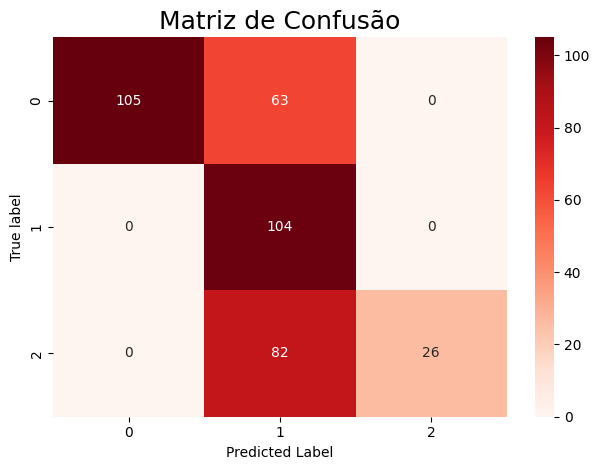

In [24]:
#MATRIX DE CONFUSÃO


fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(label_aux, pred), annot=True, 
            ax=ax, fmt='d', cmap='Reds')
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

In [31]:
df=pd.DataFrame({'real': label_aux, 'previsao':pred, 'partida_id':features_aux['partida_id']})

print(df)


      real  previsao  partida_id
1496     3         3        7646
1497     3         2        7647
1498     2         2        7648
1499     1         1        7649
1500     2         2        7650
...    ...       ...         ...
1871     1         2        8021
1872     2         2        8022
1873     2         2        8023
1874     1         1        8024
1875     2         2        8025

[380 rows x 3 columns]


<Axes: xlabel='previsao', ylabel='real'>

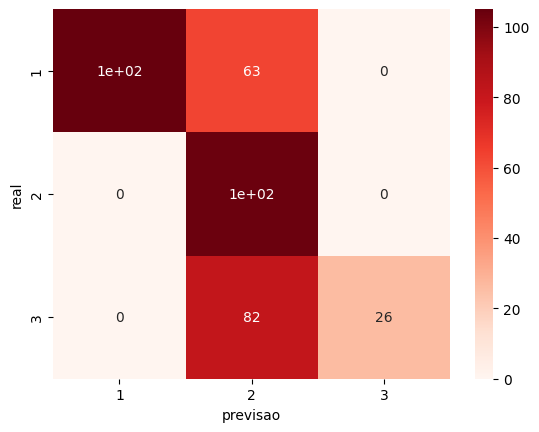

In [32]:
#confusion Matrix
df=pd.DataFrame(df,columns=['real','previsao' ])

cf_matrix=pd.crosstab(df['real'], df['previsao'], rownames=['real'] , colnames=['previsao'])

sns.heatmap(cf_matrix, annot=True, cmap='Reds')

lIMITES DO sEGUNDO

In [ ]:
X = df_model.drop(['resultado'], axis = 1)
y = df_model['resultado']

SEED = 23
np.random.seed(SEED)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y)

print('O dataset de treino possui {} linhas e o de teste {} linhas.'.format(X_train.shape[0], X_test.shape[0]))

In [ ]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)
predict = model.predict(X_train)

accuracy = accuracy_score(y_train, predict) * 100
print ("A acurácia foi de {:.2f}%.".format(accuracy))

In [ ]:
predict = model.predict(X_train)

In [ ]:
X_news = df_aux.drop('resultado', axis = 1)
y_news = df_aux['resultado']

predict = model.predict(X_news)

accuracy = accuracy_score(y_news, predict) * 100
print ("A acurácia foi de {:.2f}%.".format(accuracy))

In [ ]:

from sklearn.model_selection import KFold


SEED = 42
np.random.seed(SEED)

#Utilizando o StratifiedKFold temos que ao treinar e testar os modelos com os folds contendo a mesma proporção de informações
cv = StratifiedKFold(n_splits = 5, shuffle = True)


model = DecisionTreeClassifier(max_depth=3)
results = cross_val_score(model, X_train, 
                          y_train, cv = cv, scoring = 'accuracy')
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'
           .format((mean - 2*dv)*100, (mean + 2*dv)*100))

intervalo(results)

In [ ]:
#Testando varios estimadores
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

np.random.seed(SEED)
cv = StratifiedKFold(n_splits = 5, shuffle = True)

model_dtree = DecisionTreeClassifier(max_depth=3)
model_svc = SVC()
model_log = LogisticRegression(solver='liblinear')
model_rand = RandomForestClassifier(n_estimators=100)

models = [model_dtree, model_svc, model_log, model_rand]
name = ['Árvore de Decisão', 'SVC', 
        'Regressão Logística', 'Random Forest']
count = 0
for item in models:
    np.random.seed(SEED)
    results = cross_val_score(item, X_train, y_train, cv = cv, 
                              scoring = 'accuracy')
    mean = results.mean()
    dv = results.std()
    print('Acurácia média - Modelo {}: {:.2f}%'.format(name[count], mean*100))
    print('Intervalo de acurácia - Modelo {}: [{:.2f}% ~ {:.2f}%]\n'.format(name[count], (mean - 2*dv)*100, (mean + 2*dv)*100))
    count += 1

In [ ]:

clf_LR = LogisticRegression(multi_class='multinomial',max_iter=2000)
clf_LR.fit(X_train, y_train)
pred= clf_LR.predict(X_train)

lg_acc = accuracy_score(y_train, pred)
f1=f1_score(y_train,pred,average = 'micro')
print ('Acurácia LogisticRegression:{}'.format(lg_acc))
print ('F1 Score:{}'.format(f1) )

In [ ]:
#Executando a previsao

previsao= df_aux.drop('resultado', axis = 1)

game_id_full=df_aux['partida_id']
res_full=df_aux['resultado']



pred=clf_LR.predict(previsao)

regre_logistc_pred=pd.DataFrame({'real': res_full, 'previsao':pred, 'partida_id':game_id_full})

print(regre_logistc_pred)

In [ ]:
#confusion Matrix

tt=pd.DataFrame(regre_logistc_pred,columns=['real','previsao' ])

cf_matrix=pd.crosstab(tt['real'], tt['previsao'], rownames=['real'] , colnames=['previsao'])

sns.heatmap(cf_matrix, annot=True, cmap='Reds')

In [ ]:
from sklearn.model_selection import cross_val_predict


np.random.seed(SEED)
cv = StratifiedKFold(n_splits = 5, shuffle = True)

model = LogisticRegression(solver='liblinear')
y_pred = cross_val_predict(model, X_train, y_train, cv = cv)



In [ ]:
from sklearn.metrics import classification_report
# relatório do modelo
print('Relatório de classificação:\n', classification_report(y_train, y_pred, digits=4))

In [ ]:
from sklearn.metrics import classification_report
# relatório do modelo
print('Relatório de classificação:\n', classification_report(y_train, y_pred, digits=4))

## Aqui em baixo antigo modelo

In [ ]:
# listando features categoricas e numéricas:
#categorical_attributes = list(df_model.select_dtypes(include=['object']).columns)
#numerical_attributes = list(df_model.select_dtypes(include=['float64', 'int64']).columns)
#print('categorical_attributes:', categorical_attributes)
#print('numerical_attributes:', numerical_attributes)

In [ ]:
#Deixar somente as variáveis numericas 
num_data  =df.drop(['partida_id','rodada','mandante', 'visitante', 'total_gols','vencedor'],axis=1)
num_data

In [ ]:
#separa as features 
features = num_data.drop(['resultado'],axis=1)
#separa as labels
labels = num_data['resultado']


print('Features')
print (features.head())

print (" ")
print ('#############')
print (" ")


print ('Labels')
print (labels.head()) 

In [ ]:
#transformando as formações em dados numericos
le = preprocessing.LabelEncoder()
le.fit(features['formacao_mandante'])
features['formacao_mandante'] = le.transform(features["formacao_mandante"])
features['formacao_visitante'] = le.transform(features["formacao_visitante"])

print('Features')
print (features.head())

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(features['clube_mandante'])
features['clube_mandante'] = le.transform(features["clube_mandante"])
features['clube_visitante'] = le.transform(features["clube_visitante"])

print('Features')
print (features.head())

In [ ]:
features.isna().sum()

In [ ]:
#Escoolhendo as melhores features com Kbest

features_list = ('formacao_mandante','formacao_visitante','mandante_placar','visitante_placar',
                 'chutes_mandante','chutes_no_alvo_mandante','posse_de_bola_mandante',
                 'passes_mandante','precisao_passes_mandante','faltas_mandante','cartao_amarelo_mandante',
                 'cartao_vermelho_mandante','impedimentos_mandante','escanteios_mandante',
                 'rodata_visitante','chutes_visitante','chutes_no_alvo_visitante','posse_de_bola_visitante',
                 'passes_visitante','precisao_passes_visitante','faltas_visitante','cartao_amarelo_visitante',
                 'cartao_vermelho_visitante','impedimentos_visitante','escanteios_visitante')


k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:27])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)

In [ ]:
#separa as features com base no Kbest
#oldfeatures  = num_data.drop(['cartao_amarelo_mandante', 'impedimentos_visitante', 'cartao_amarelo_visitante', 'temporada', 'rodata_visitante', 'precisao_passes_mandante', 'faltas_mandante', 'chutes_visitante', 'escanteios_mandante', 'cartao_vermelho_mandante', 'escanteios_visitante', 'chutes_no_alvo_mandante', 'cartao_vermelho_visitante'],axis=1)
features  = features.drop(['cartao_vermelho_visitante','escanteios_mandante','faltas_visitante', 'precisao_passes_mandante', 'passes_visitante', 'cartao_amarelo_visitante', 'cartao_vermelho_mandante', 'impedimentos_visitante', 'chutes_visitante', 'faltas_mandante','cartao_amarelo_mandante', 'posse_de_bola_visitante', 'chutes_no_alvo_visitante', 'rodata_visitante', 'impedimentos_mandante', 'chutes_no_alvo_mandante', 'posse_de_bola_mandante', 'formacao_visitante', 'mandante_placar', 'escanteios_visitante'],axis=1)

print('Features')
print (features.head())

print ('=========')

print ('Labels')
print (Y.head())

In [ ]:
#devido ao OVERFITING, estou realizando um Low Variance Filter como tentativa de resolução
#normalize = normalize(features) 
#data_scaled = pd.DataFrame(normalize)
#data_scaled.var()

In [ ]:
#storing the variance and name of variables
#variance = data_scaled.var()
#columns = features.columns

#print(variance)

In [ ]:
#saving the names of variables having variance more than a threshold value

#variable = [ ]

#or i in range(0,len(variance)):
#    if variance[i]>=0.0: #setting the threshold as 1%
#        variable.append(columns[i-1])


#variable

#for i in range(0,len(variance)):
#    print(variance[i])

In [ ]:
# criando um novo dataframe usando as variáveis ​​acima
#new_data = features[variable]

 # primeiras cinco linhas dos novos dados
#new_data.head() 

In [ ]:
# Normalizando os dados de entrada(features)
scaler = MinMaxScaler().fit(features)
X = scaler.transform(features)

print ('Features: ',X.shape)
print (X)

In [ ]:
# Realiza a divisão dos dados de treine e teste e deixa do espaço 2650 a 3090 para validação do ml
#X_train = features_scale[:2000 ]
#X_test = features_scale[2000:2650]
#y_train = labels[:2000]
#y_test = labels[2000:2650]

# Realiza a divisão de dados de treino e teste, separando 20% para teste

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

print(Y.shape)

In [ ]:
#Treinando e testando os modelos
print ('LogisticRegression')

clf_LR = LogisticRegression(multi_class='multinomial',max_iter=2000)
clf_LR.fit(X_train, y_train)
pred= clf_LR.predict(X_train)

lg_acc = accuracy_score(y_train, pred)
f1=f1_score(y_train,pred,average = 'micro')
print ('Acurácia LogisticRegression:{}'.format(lg_acc))
print ('F1 Score:{}'.format(f1) )

In [ ]:
#Testando LogistRegression hyper parameters

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid)

search.fit(X_train,y_train)
clf = search.best_estimator_
pred= clf.predict(X_train)
lg_acc = accuracy_score(y_train, pred)


f1=f1_score(y_train,pred,average = 'macro')

print ('Acurácia LogisticRegression:{}'.format(lg_acc))
print ('F1 Score:{}'.format(f1) )

print (clf)

In [ ]:
#Treinando e testando os modelos
print ('SVC')


clf = SVC()
clf.fit(X_train, y_train)
pred= clf.predict(X_train)

svc_acc = accuracy_score(y_train, pred)
f1=f1_score(y_train,pred, average='micro')
print ('Acurácia SVC:{}'.format(svc_acc))
print ('F1 Score:{}'.format(f1) )

In [ ]:
#Testando SVC hyper parameters

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

search = GridSearchCV(SVC(), param_grid)

search.fit(X_train,y_train)
clf_SVC = search.best_estimator_
pred= clf_SVC.predict(X_train)
acc = accuracy_score(y_train, pred)


f1=f1_score(y_train,pred,average = 'micro')

print ('F1 Score:{}'.format(f1))

print ('Acurácia LogisticRegression:{}'.format(acc))

print(clf_SVC)

In [ ]:
#Treinando e testando os modelos
print ('Decision Tree')


clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred= clf.predict(X_train)

dt_acc = accuracy_score(y_train, pred)
f1=f1_score(y_train,pred, average='macro')
print ('Acurácia Tree:{}'.format(dt_acc))
print ('F1 Score:{}'.format(f1) )


n_estimators = [10, 50, 100, 200]
max_depth = [3, 10, 20, 40]

In [ ]:
#Treinando e testando os modelos
print ('Naive baeys')


clf = GaussianNB()
clf.fit(X_train, y_train)
pred= clf.predict(X_train)

nb_acc = accuracy_score(y_train, pred)
f1=f1_score(y_train,pred, average='micro')
print ('Acurácia Naive baeys:{}'.format(nb_acc))
print ('F1 Score:{}'.format(f1) )

In [ ]:
from sklearn.model_selection import cross_val_score
SEED = 42
np.random.seed(SEED)
model = DecisionTreeClassifier(max_depth=3)
results = cross_val_score(model, X_train, 
                          y_train, cv = 5, scoring = 'accuracy')
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
    
intervalo(results)

In [ ]:
#Executando a previsao

previsao=features_scale[2650:]

game_id_full=df['partida_id']
game_id=game_id_full[2650:]

res_full=df['resultado']
res=res_full[2650:]


pred=clf_LR.predict(previsao)

df=pd.DataFrame({'real': res, 'previsao':pred, 'partida_id':game_id})

print(df)

In [ ]:

#confusion Matrix

df=pd.DataFrame(df,columns=['real','previsao' ])

cf_matrix=pd.crosstab(df['real'], df['previsao'], rownames=['real'] , colnames=['previsao'])

sns.heatmap(cf_matrix, annot=True, cmap='Reds')

In [ ]:
# relatório do modelo
print('Relatório de classificação:\n', classification_report(y_train, y_pred, digits=4))

In [ ]:
# Functions for plotting
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

In [ ]:
# Let's examine the distribution of the predicted values of the training data
Title = '-'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [ ]:


# Let's examine the distribution of the predicted values of the training data
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_test, yhat_teste, "Actual Values (teste)", "Predicted Values (teste)", Title)
